# Kaggle Playground Series - Exploring Mental Health Data

[Kaggle Playground Series - s04-e11](https://www.kaggle.com/competitions/playground-series-s4e11/overview)

## Configuration

In [400]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from kaggle import KaggleApi

from scipy.stats import chi2_contingency, randint, ttest_ind, mannwhitneyu, ks_2samp, pointbiserialr
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier


### Helper Functions

In [401]:
def kaggle_download(competition_name, output_dir):
    api = KaggleApi()
    api.authenticate()
    os.makedirs(output_dir, exist_ok=True)
    api.competition_download_files(competition_name, path=output_dir)
    zip_path = os.path.join(output_dir, f"{competition_name}.zip")
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Extracted all files to '{output_dir}'")
        os.remove(zip_path)
    else:
        print(f"No zip file found at '{zip_path}'")

def categorical_tests(df, feature, label):
    cont_table = pd.crosstab(df[feature], df[label])
    chi2, p, _, _ = chi2_contingency(cont_table)
    n = cont_table.values.sum()
    cramers_v = np.sqrt(chi2 / (n * (min(cont_table.shape) - 1)))
    print(f"Feature: {feature}")
    print(f"Chi-Square Statistic: {round(chi2, 2)}")
    print(f"P-value: {round(p, 10)}")
    print(f"Cramér's V: {round(cramers_v, 3)}")

def categorical_exploration(df, feature, label, n):
    top_cats = df[feature].value_counts().index[:n]
    top = df[df[feature].isin(top_cats)]
    _, ax = plt.subplots(figsize=(8, 4))
    mosaic(top, [feature, label], ax=ax)
    plt.xlabel(feature)
    plt.show()
    categorical_tests(top, feature, label)

def top_contributors(df, feature, prop):
    categories = df[feature].value_counts(normalize=True, dropna=False).to_frame().reset_index()
    categories["cumulative"] = categories["proportion"].cumsum()
    categories = categories[categories["proportion"] >= prop]
    return categories, categories[feature].to_list()

def numeric_exploration(df, feature, label):
    sns.boxenplot(data=df, x=label, y=feature)
    group0 = df[df[label] == 0][feature]
    group1 = df[df[label] == 1][feature]
    stat, p_value = ttest_ind(group0, group1, equal_var=False)
    print(f"Statistic: {stat}, p-value: {p_value}")
    stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')
    print(f"Statistic: {stat}, p-value: {p_value}")
    stat, p_value = ks_2samp(group0, group1)
    print(f"Statistic: {stat}, p-value: {p_value}")
    correlation, p_value = pointbiserialr(df[feature], df[label])
    print(f"Correlation: {correlation}, p-value: {p_value}")

### Load, Extract and Transform Data

In [402]:
kaggle_download("playground-series-s4e11", "data")   

Extracted all files to 'data'


In [403]:
# load the training dataset
train_df = pd.read_csv("data/train.csv")

# drop the id columns
train_df.drop("id", axis=1, inplace=True)

# explore the data types
train_df.dtypes

Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

Rename & reformat columns names.

In [404]:
rename_dict = {
        "Have you ever had suicidal thoughts ?" : "suicidal thoughts",
        "Family History of Mental Illness" : "family history",
        "Working Professional or Student" : "professional or student"
    }

train_df = train_df.rename(
    columns=rename_dict
)

train_df.columns = [col.lower() for col in train_df.columns]

list(train_df.columns)

['name',
 'gender',
 'age',
 'city',
 'professional or student',
 'profession',
 'academic pressure',
 'work pressure',
 'cgpa',
 'study satisfaction',
 'job satisfaction',
 'sleep duration',
 'dietary habits',
 'degree',
 'suicidal thoughts',
 'work/study hours',
 'financial stress',
 'family history',
 'depression']

## EDA and Feature Engineering

In [405]:
label = "depression"

### Categorical Features

Ignore the name field as a potential feature.

In [406]:
train_df.select_dtypes(include=["object"]).describe()

,name,gender,city,professional or student,profession,sleep duration,dietary habits,degree,suicidal thoughts,family history
count,140700,140700,140700,140700,104070,140700,140696,140698,140700,140700
unique,422,2,98,2,64,36,23,115,2,2
top,Rohan,Male,Kalyan,Working Professional,Teacher,Less than 5 hours,Moderate,Class 12,No,No
freq,3178,77464,6591,112799,24906,38784,49705,14729,71138,70758


#### Binary Categories

In [407]:
binary_features = ["gender", "professional or student", "suicidal thoughts", "family history"]
train_df.isnull().sum()

name                            0
gender                          0
age                             0
city                            0
professional or student         0
profession                  36630
academic pressure          112803
work pressure               27918
cgpa                       112802
study satisfaction         112803
job satisfaction            27910
sleep duration                  0
dietary habits                  4
degree                          2
suicidal thoughts               0
work/study hours                0
financial stress                4
family history                  0
depression                      0
dtype: int64

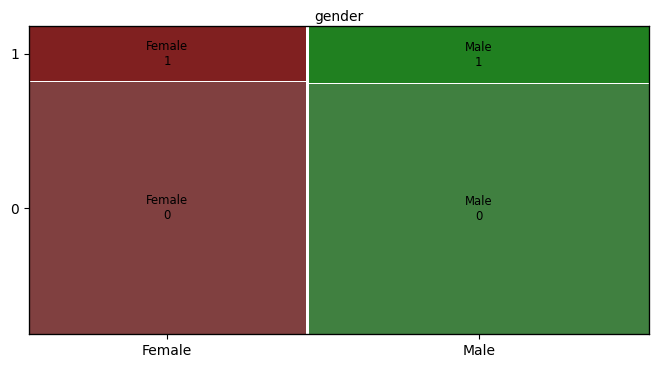

Feature: gender
Chi-Square Statistic: 9.29
P-value: 0.0023046498
Cramér's V: 0.008


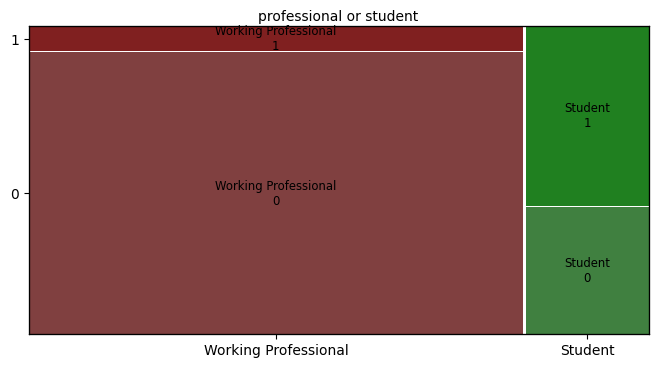

Feature: professional or student
Chi-Square Statistic: 38157.59
P-value: 0.0
Cramér's V: 0.521


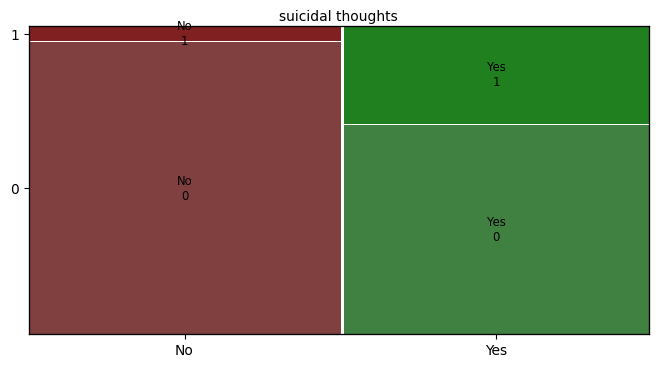

Feature: suicidal thoughts
Chi-Square Statistic: 17142.06
P-value: 0.0
Cramér's V: 0.349


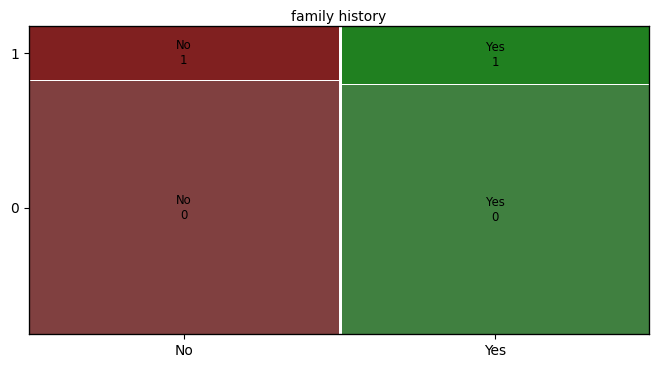

Feature: family history
Chi-Square Statistic: 38.23
P-value: 6e-10
Cramér's V: 0.016


In [408]:
for feature in binary_features:
    categorical_exploration(train_df, feature, label, 2)

#### Sleep Duration

In [409]:
feature = "sleep duration"

In [410]:
categories = train_df[feature].value_counts(normalize=True, dropna=False)
categories

sleep duration
Less than 5 hours    0.275650
7-8 hours            0.262751
More than 8 hours    0.232594
5-6 hours            0.228443
3-4 hours            0.000085
6-7 hours            0.000057
4-5 hours            0.000050
2-3 hours            0.000036
4-6 hours            0.000036
6-8 hours            0.000028
1-6 hours            0.000028
No                   0.000028
9-11 hours           0.000014
10-11 hours          0.000014
Sleep_Duration       0.000014
Unhealthy            0.000014
45                   0.000014
8-9 hours            0.000014
10-6 hours           0.000007
9-5                  0.000007
45-48 hours          0.000007
3-6 hours            0.000007
Work_Study_Hours     0.000007
49 hours             0.000007
than 5 hours         0.000007
Pune                 0.000007
9-6 hours            0.000007
8 hours              0.000007
35-36 hours          0.000007
Indore               0.000007
1-3 hours            0.000007
55-66 hours          0.000007
Moderate             0.00

In [411]:
results, categories = top_contributors(train_df, feature, 0.01)
results

,sleep duration,proportion,cumulative
0,Less than 5 hours,0.275650,0.275650
1,7-8 hours,0.262751,0.538401
2,More than 8 hours,0.232594,0.770995
3,5-6 hours,0.228443,0.999439


Sleep Duration is an inconsistent column, the most common responses (99%) are:
- Less than 5 hours (28%)
- 7-8 hours (26%)
- More than 8 hours (23%)
- 5-6 hours (22%)

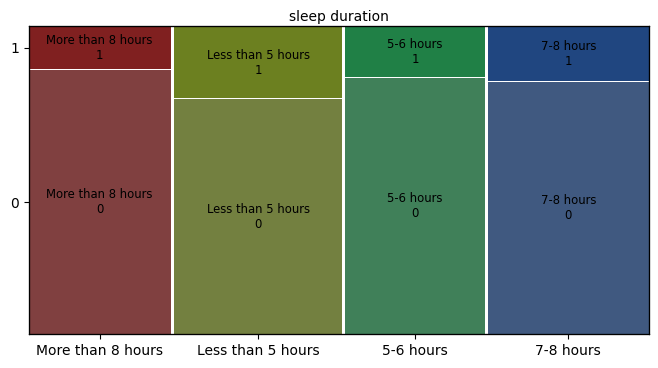

Feature: sleep duration
Chi-Square Statistic: 1197.45
P-value: 0.0
Cramér's V: 0.092


In [412]:
n_categories = len(categories)
categorical_exploration(train_df, feature, "depression", n_categories)

As the majority of records are part of these four categories, the remainder of categories will be invalidated and infilled as part of preprocessing.

In [413]:
train_df[feature] = train_df[feature].apply(lambda x: x if x in categories else "Unknown")
train_df[feature].value_counts(dropna=False)

sleep duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
Unknown                 79
Name: count, dtype: int64

#### Dietary Habits

In [414]:
feature = "dietary habits"

In [415]:
categories = train_df[feature].value_counts(normalize=True, dropna=False)
categories

dietary habits
Moderate             0.353269
Unhealthy            0.328550
Healthy              0.317989
NaN                  0.000028
Yes                  0.000014
No                   0.000014
More Healthy         0.000014
Class 12             0.000007
Indoor               0.000007
Male                 0.000007
Vegas                0.000007
M.Tech               0.000007
Less Healthy         0.000007
No Healthy           0.000007
Hormonal             0.000007
Electrician          0.000007
1.0                  0.000007
Mihir                0.000007
Less than Healthy    0.000007
3                    0.000007
Gender               0.000007
BSc                  0.000007
Pratham              0.000007
2                    0.000007
Name: proportion, dtype: float64

In [416]:
results, categories = top_contributors(train_df, feature, 0.01)
results

,dietary habits,proportion,cumulative
0,Moderate,0.353269,0.353269
1,Unhealthy,0.328550,0.681819
2,Healthy,0.317989,0.999808


Dietary Habits is an inconsistent column, the most common responses (99%) are:
- Moderate (35%)
- Unhealthy (32%)
- Healthy (32%)

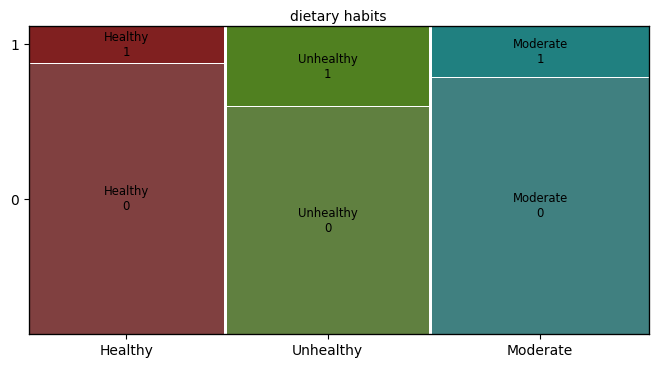

Feature: dietary habits
Chi-Square Statistic: 3238.67
P-value: 0.0
Cramér's V: 0.152


In [417]:
n_categories = len(categories)
categorical_exploration(train_df, feature, "depression", n_categories)

In [418]:
train_df[feature] = train_df[feature].apply(lambda x: x if x in categories else "Unknown")
train_df[feature].value_counts(dropna=False)

dietary habits
Moderate     49705
Unhealthy    46227
Healthy      44741
Unknown         27
Name: count, dtype: int64

#### Degree

In [419]:
feature = "degree"

In [420]:
categories = train_df[feature].value_counts(normalize=True, dropna=False)
categories

degree
Class 12    0.104684
B.Ed        0.083092
B.Arch      0.062132
B.Com       0.057662
B.Pharm     0.041620
              ...   
Vivaan      0.000007
MTech       0.000007
29          0.000007
LLCom       0.000007
Advait      0.000007
Name: proportion, Length: 116, dtype: float64

Degree is an inconsistent column with high cardinality, will groups into the following categories:
- C - High School
- B - Bachelors
- M - Masters
- P - PhD
- L - (???)
- U - Unknown

In [421]:
train_df[feature] = train_df[feature].apply(lambda x: x[:1] if isinstance(x, str) else "Unknown")
train_df[feature] = train_df[feature].apply(lambda x: x if x in ["B", "M", "C", "L", "P"] else "Unknown")

In [422]:
categories = train_df[feature].value_counts(normalize=True, dropna=False)
categories

degree
B          0.467726
M          0.341116
C          0.104698
L          0.064030
P          0.022090
Unknown    0.000341
Name: proportion, dtype: float64

In [423]:
results, categories = top_contributors(train_df, feature, 0.01)
results

,degree,proportion,cumulative
0,B,0.467726,0.467726
1,M,0.341116,0.808842
2,C,0.104698,0.913539
3,L,0.064030,0.977569
4,P,0.022090,0.999659


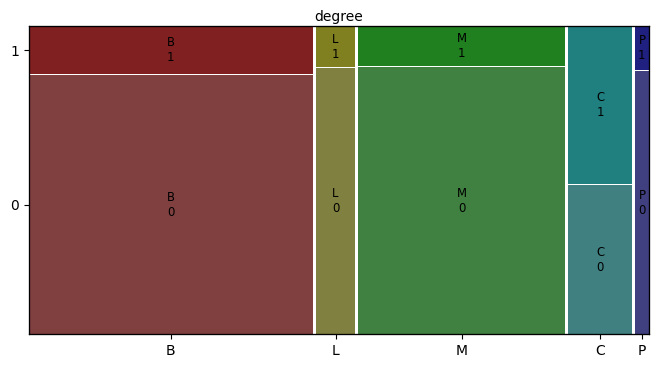

Feature: degree
Chi-Square Statistic: 12266.16
P-value: 0.0
Cramér's V: 0.295


In [424]:
n_categories = len(categories)
categorical_exploration(train_df, feature, "depression", n_categories)

#### City

In [425]:
feature = "city"

In [426]:
categories = train_df[feature].value_counts(normalize=True, dropna=False)
categories

city
Kalyan         0.046844
Patna          0.042104
Vasai-Virar    0.040974
Kolkata        0.040434
Ahmedabad      0.039893
                 ...   
Shrey          0.000007
Ivaan          0.000007
Vaanya         0.000007
Gaurav         0.000007
Unirar         0.000007
Name: proportion, Length: 98, dtype: float64

In [427]:
results, categories = top_contributors(train_df, feature, 0.01)
results

,city,proportion,cumulative
0,Kalyan,0.046844,0.046844
1,Patna,0.042104,0.088948
2,Vasai-Virar,0.040974,0.129922
3,Kolkata,0.040434,0.170355
4,Ahmedabad,0.039893,0.210249
5,Meerut,0.039289,0.249538
6,Ludhiana,0.037143,0.286681
7,Pune,0.037029,0.323710
8,Rajkot,0.037008,0.360718
9,Visakhapatnam,0.036787,0.397505


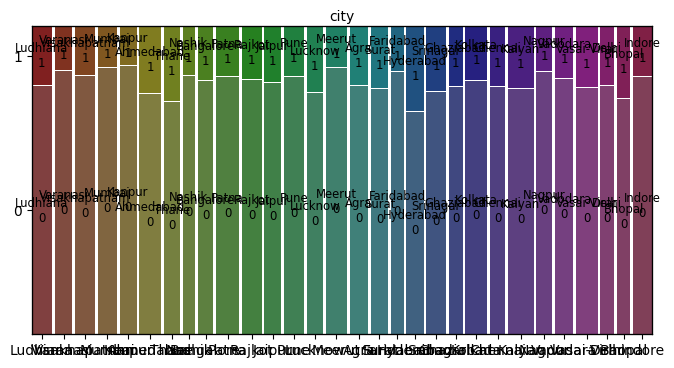

Feature: city
Chi-Square Statistic: 1055.12
P-value: 0.0
Cramér's V: 0.087


In [428]:
n_categories = len(categories)
categorical_exploration(train_df, feature, "depression", n_categories)

#### Profession

In [429]:
feature = "profession"

In [430]:
categories = train_df[feature].value_counts(normalize=True, dropna=False)
categories

profession
NaN                  0.260341
Teacher              0.177015
Content Writer       0.055537
Architect            0.031059
Consultant           0.030057
                       ...   
Dev                  0.000007
BE                   0.000007
B.Com                0.000007
Family Consultant    0.000007
Yuvraj               0.000007
Name: proportion, Length: 65, dtype: float64

Infill the missing values with Student

In [431]:
train_df[feature] = train_df[feature].apply(lambda x: "Student" if pd.isna(x) else x)
categories = train_df[feature].value_counts(normalize=True, dropna=False)
categories

profession
Student              0.260391
Teacher              0.177015
Content Writer       0.055537
Architect            0.031059
Consultant           0.030057
                       ...   
Dev                  0.000007
BE                   0.000007
B.Com                0.000007
Family Consultant    0.000007
Yuvraj               0.000007
Name: proportion, Length: 64, dtype: float64

In [432]:
results, categories = top_contributors(train_df, feature, 0.01)
results

,profession,proportion,cumulative
0,Student,0.260391,0.260391
1,Teacher,0.177015,0.437406
2,Content Writer,0.055537,0.492942
3,Architect,0.031059,0.524001
4,Consultant,0.030057,0.554058
5,HR Manager,0.028586,0.582644
6,Pharmacist,0.027669,0.610313
7,Doctor,0.023134,0.633447
8,Business Analyst,0.022466,0.655913
9,Entrepreneur,0.021095,0.677008


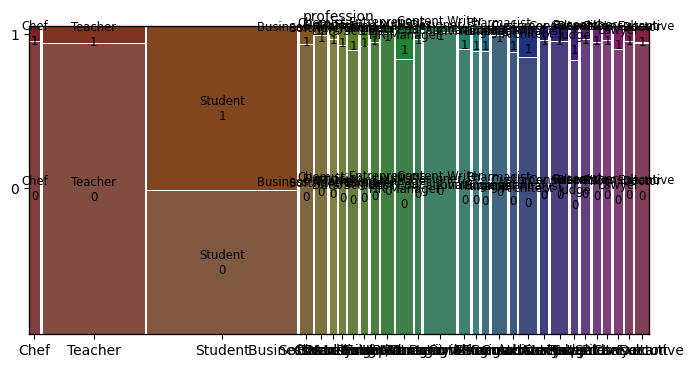

Feature: profession
Chi-Square Statistic: 40424.8
P-value: 0.0
Cramér's V: 0.551


In [433]:
n_categories = len(categories)
categorical_exploration(train_df, feature, "depression", n_categories)

## Numeric Feature Engineering

In [434]:
train_df.select_dtypes(exclude=["object"]).drop("depression", axis=1).describe()

,age,academic pressure,work pressure,cgpa,study satisfaction,job satisfaction,work/study hours,financial stress
count,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000
mean,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983
std,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633
min,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000
25%,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000
50%,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000
75%,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000
max,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000


In [435]:
train_df.select_dtypes(exclude=["object"]).drop("depression", axis=1).isnull().sum()

age                        0
academic pressure     112803
work pressure          27918
cgpa                  112802
study satisfaction    112803
job satisfaction       27910
work/study hours           0
financial stress           4
dtype: int64

#### Satisfaction (job / study)

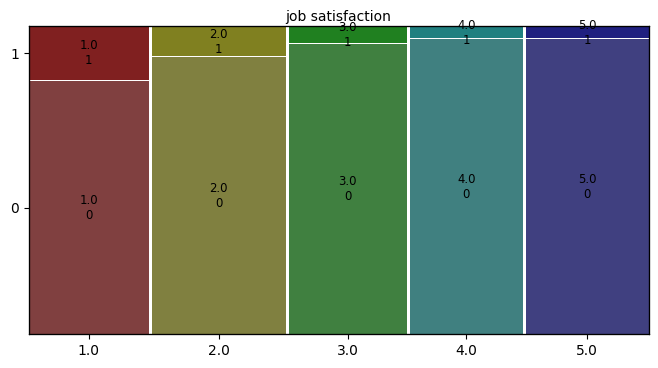

Feature: job satisfaction
Chi-Square Statistic: 3898.85
P-value: 0.0
Cramér's V: 0.186


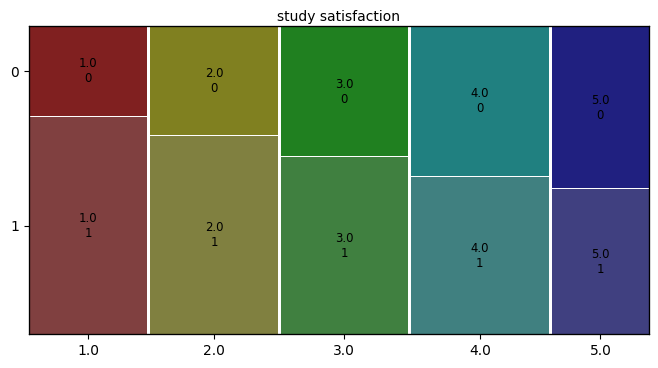

Feature: study satisfaction
Chi-Square Statistic: 793.06
P-value: 0.0
Cramér's V: 0.169


In [436]:
categorical_exploration(train_df.sort_values("job satisfaction"), "job satisfaction", "depression", 100)
categorical_exploration(train_df.sort_values("study satisfaction"), "study satisfaction", "depression", 100)

create a combined satisfaction column

In [437]:
train_df["satisfaction"] = np.floor(train_df[["study satisfaction", "job satisfaction"]].mean(axis=1))

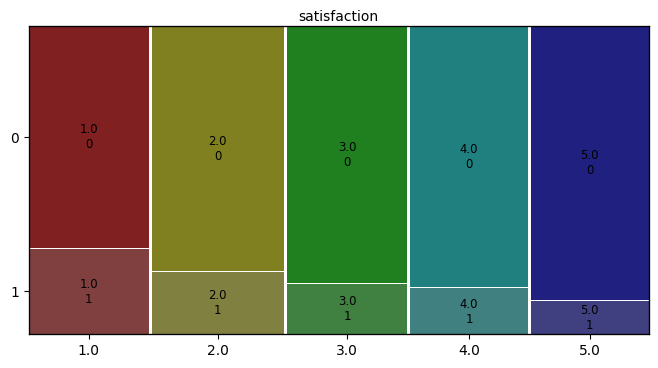

Feature: satisfaction
Chi-Square Statistic: 3058.91
P-value: 0.0
Cramér's V: 0.147


In [438]:
categorical_exploration(train_df.sort_values("satisfaction"), "satisfaction", "depression", 100)

#### Pressure (academic / work)

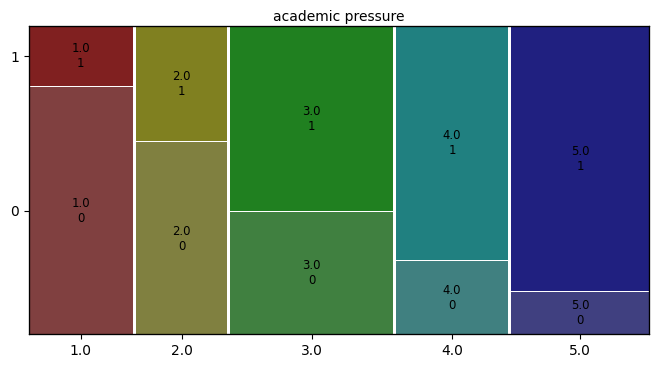

Feature: academic pressure
Chi-Square Statistic: 6426.01
P-value: 0.0
Cramér's V: 0.48


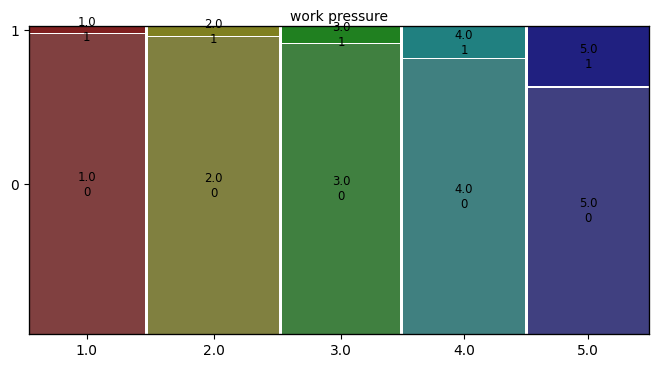

Feature: work pressure
Chi-Square Statistic: 6088.28
P-value: 0.0
Cramér's V: 0.232


In [439]:
categorical_exploration(train_df.sort_values("academic pressure"), "academic pressure", "depression", 100)
categorical_exploration(train_df.sort_values("work pressure"), "work pressure", "depression", 100)

In [440]:
train_df["pressure"] = np.floor(train_df[["academic pressure", "work pressure"]].mean(axis=1))

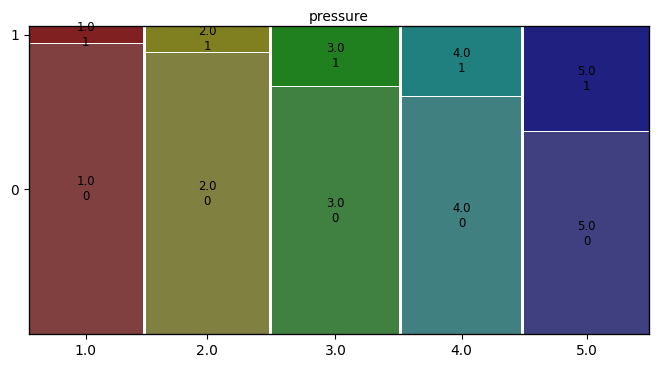

Feature: pressure
Chi-Square Statistic: 10159.71
P-value: 0.0
Cramér's V: 0.269


In [441]:
categorical_exploration(train_df.sort_values("pressure"), "pressure", "depression", 100)

#### Work / Study Hours

In [442]:
feature = "work/study hours"

Statistic: -78.07473109210305, p-value: 0.0
Statistic: 1049243087.0, p-value: 0.0
Statistic: 0.22517890968776993, p-value: 0.0
Correlation: 0.191746195662048, p-value: 0.0


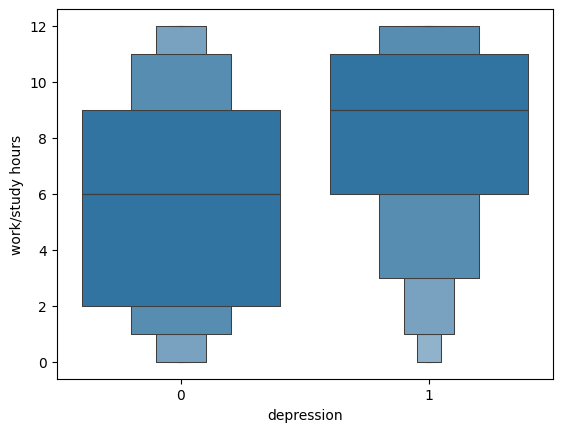

In [443]:
numeric_exploration(train_df, feature, label)

#### Age

In [444]:
feature = "age"

Statistic: 350.6592437828074, p-value: 0.0
Statistic: 2663774674.5, p-value: 0.0
Statistic: 0.7315115765697986, p-value: 0.0
Correlation: -0.5646712107170868, p-value: 0.0


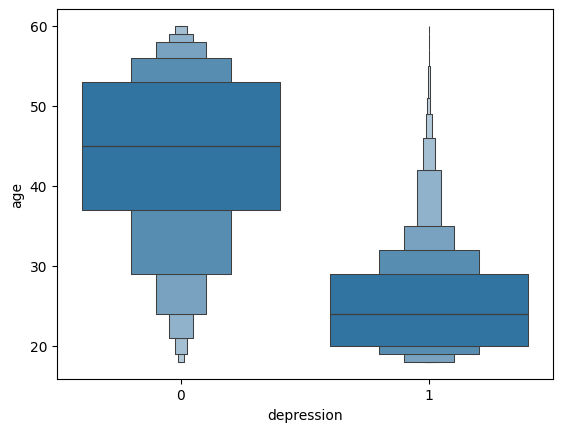

In [445]:
numeric_exploration(train_df, feature, label)

#### Financial Stress

In [446]:
feature = "financial stress"

Statistic: nan, p-value: nan
Statistic: nan, p-value: nan
Statistic: nan, p-value: nan
Correlation: nan, p-value: nan


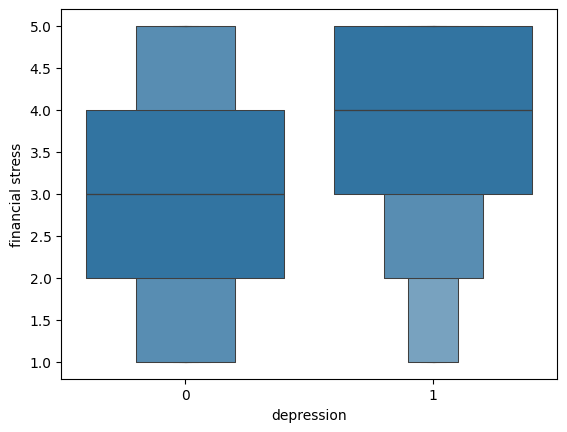

In [447]:
numeric_exploration(train_df, feature, label)

<Axes: >

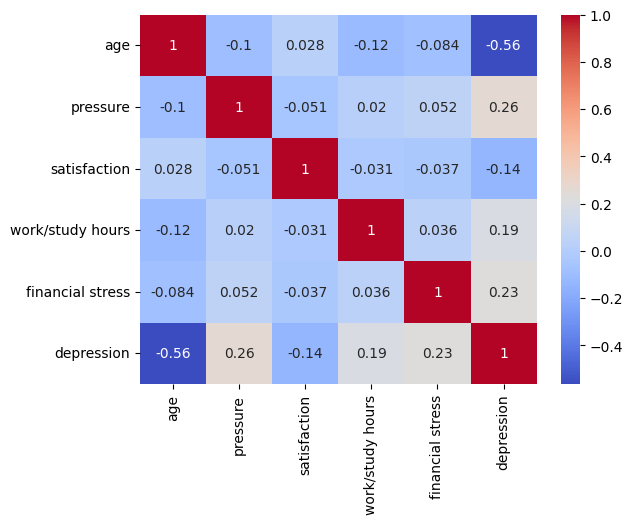

In [448]:
subset = train_df[["age", "pressure", "satisfaction", "work/study hours", "financial stress", "depression"]]
sns.heatmap(data=subset.corr(), cmap="coolwarm", annot=True)

In [449]:
# sns.pairplot(data=subset.sample(frac=0.1, replace=False), hue="depression")

## Modelling

### Data Categories

In [450]:
ordinal_dict = {
    "dietary habits" : ["Unhealthy", "Moderate", "Healthy", "Unknown"],
    "sleep duration" : ["Less than 5 hours", "5-6 hours", "7-8 hours", "More than 8 hours", "Unknown"],
    "degree" : ["C", "B", "M", "L", "P", "Unknown"],
}

# one hot encoding list
ohe_list = ["gender", "professional or student", "family history", "suicidal thoughts"]

# ordinal encoding list
ord_list = list(ordinal_dict.keys())

# numeric list
num_list = ["work/study hours", "age", "satisfaction", "pressure", "financial stress"]

### Data Preparation

In [451]:
def preprocessing(df, ord_dict, rename_dict):
    df.rename(columns=rename_dict, inplace=True)
    df.columns = [col.lower() for col in df.columns]
    df["pressure"] = np.floor(df[["academic pressure", "work pressure"]].mean(axis=1))
    df["pressure"] = df["pressure"].apply(lambda x: x if x > 0 else 0)
    
    df["satisfaction"] = np.floor(df[["study satisfaction", "job satisfaction"]].mean(axis=1))
    df["satisfaction"] = df["satisfaction"].apply(lambda x: x if x > 0 else 0)
    
    df["financial stress"] = df["financial stress"].apply(lambda x: x if x > 0 else 0)
    
    
    df.drop(["academic pressure", "work pressure", "study satisfaction", "job satisfaction"], axis=1, inplace=True)
    
    df["degree"] = df["degree"].apply(lambda x: x[:1] if isinstance(x, str) else "Unknown")
    for feature, vals in ord_dict.items():
        df[feature] = df[feature].apply(lambda x: x if x in vals else "Unknown")
    return df

### Data Preprocessing

In [452]:
numeric_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()) 
])

categorical_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop="first")) 
])

ordinal_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('oe', OrdinalEncoder(categories=[val for val in ordinal_dict.values()])) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocess, num_list),
        ('cat', categorical_preprocess, ohe_list),
        ('ord', ordinal_preprocess, ord_list),
    ]
)

In [453]:
X = train_df.drop("depression", axis=1)#[ohe_list+ord_list+num_list]#+lab_list]
y = train_df["depression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [454]:
model = pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LGBMClassifier())
])

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 20454, number of negative: 92106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181716 -> initscore=-1.504762
[LightGBM] [Info] Start training from score -1.504762


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['work/study hours', 'age',
                                                   'satisfaction', 'pressure',
                                                   'financial stress']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['gender',
                                                   'professio...
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oe',
                                                                   OrdinalEncoder(categories=[['Unhealthy',
                                                                                               'Moderate',
                                                                                               'Healthy',
                                                                                               'Unknown'],
                                                                                              ['Less '
                                                                                               'than '
                                                                                               '5 '
                                                                                               'hours',
                                                                                               '5-6 '
                                                                                               'hours',
                                                                                               '7-8 '
                                                                                               'hours',
                                                                                               'More '
                                                                                               'than '
                                                                                               '8 '
                                                                                               'hours',
                                                                                               'Unknown'],
                                                                                              ['C',
                                                                                               'B',
                                                                                               'M',
                                                                                               'L',
                                                                                               'P',
                                                                                               'Unknown']]))]),
                                                  ['dietary habits',
                                           

In [455]:
model.score(X_test, y_test)

0.9376687988628287

In [456]:
test_df = pd.read_csv("./data/test.csv")
test_df = preprocessing(test_df, ordinal_dict, rename_dict)

In [457]:
submission = pd.DataFrame(
    {
        "id": test_df["id"].values,
        "Depression": model.predict(test_df),
     }
)

submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
